In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import GPyOpt

## Import MNIST data

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64')
y = mnist.target
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [5]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [6]:
train_samples = 5000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Define model and search space

Four hyperparameter to tune:
 1. Learning rate for SGD $\in [0,1]$ (log scale)
 2. $l_2$ regularisation parameter $\in [0,1]$
 3. Mini-batch size $\in [20,2000]$
 3. Number of learning epochs $\in [5,2000]$
 

In [7]:
gamma = 0.05
alpha = 50. / train_samples
n_iter = 10

clf = SGDClassifier(loss = 'log',
                    penalty='l2',
                    alpha = alpha,
                    learning_rate = 'constant',
                    eta0 = gamma,
                    n_iter = n_iter)
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha, learning_rate='constant', eta0=gamma, n_iter=n_iter)

In [8]:
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)

 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning:n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.


Sparsity with L2 penalty: 17.22%
Test score with L2 penalty: 0.8119


## Wrapper function for scoring model

In [12]:
def fit_svr_val(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        gamma = x[i,0]
        alpha = x[i,1]
        n_iter = x[i,2]
        clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha, 
                            learning_rate='constant', eta0=gamma, n_iter=n_iter)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        score = 1 - score
    return score

In [29]:
x = np.array([0.05, 50. / train_samples, 200])
print(fit_svr_val(x))

 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning:n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.


0.1805


## Bayesian Optimisation

In [18]:
domain       =[{'name': 'gamma','type': 'continuous', 'domain': (0.0001,1.)},
               {'name': 'alpha','type': 'continuous', 'domain': (0.0001,1.)},
               {'name': 'n_iter','type': 'discrete', 'domain': (20,200)}]

In [19]:
opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='EI',       # LCB acquisition
                                          acquisition_weight = 2)   # Exploration exploitation

 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning:n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning:n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning:n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning:n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklear

In [ ]:
# it may take a few seconds
opt.run_optimization(max_iter=50)

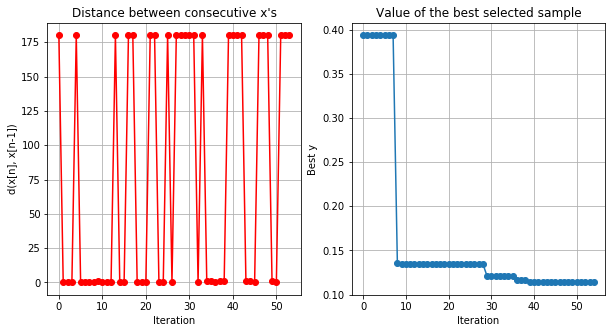

In [21]:
opt.plot_convergence()

In [26]:
min_index = np.argmin(opt.Y)
x_best = opt.X[min_index,:]
y_best = opt.Y[min_index,:]
print(x_best)
print(y_best)

[  1.00000000e-04   5.47370395e-02   2.00000000e+02]
[ 0.1137]


In [25]:
print(fit_svr_val(x_best))

 /Users/signapoop/anaconda3/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning:n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.


0.1141


In [28]:
opt.save_report("mnist")